Testing the Gaia Challenge simulated data in the case on a non costant or fixed anisotropy in the velocity of the stellar subcomponent. The profile adopted is the Osipkov-Merritt, which reads:
\begin{equation}
\beta(r)=\frac{r^2}{r^2+r^2_a}
\end{equation}
with $r_a = r_h$.

The stellar profile adopted here reads:
\begin{equation}
\nu_\ast(r) = \rho_h \left(\frac{r}{r_h}\right)^{-\gamma_\ast}\left(1+\left(\frac{r}{r_h}\right)^{\alpha_\ast}\right)^\frac{\gamma_\ast-\beta_\ast}{\alpha_\ast}
\end{equation}
with parameters values:
* $\alpha_\ast$ = 2
* $\beta_\ast$ = 5
* $r_h$ = 0.1,0.25,1 kpc

leading to the simple expression
\begin{equation}
\nu_\ast(r) = \frac{\rho_h}{\left(\frac{r}{r_h}\right)^{\gamma_\ast}\left(1+\left(\frac{r}{r_h}\right)^2\right)^{\frac{5-\gamma_\ast}{2}}}
\end{equation}

for $\gamma_\ast = 0.1,1$ this is referred to as "Plummer" and "non-Plummer" stellar profile, respectively.

In the non-Plummer profile case, the surface brightness profile has the following analytic expression:
\begin{equation}
I(R) = 2 \int^\infty_R \frac{\nu_\ast(r) r dr}{\sqrt{r^2-R^2}} = \rho_h \frac{r_h^2\left[(2r_h^2+R^2) csch^{-1}\left(\frac{R}{r_h}\right) - r_h\sqrt{r_h^2+R^2}\right]}{(r_h^2+R^2)^{3/2}}
\end{equation}

The $line-of-sight$ velocity dispersion $\sigma^2(R)$ that enters the Likelihood has the following expression
\begin{equation}
\sigma^2_{l.o.s.}(R) = 2G\mu_0\frac{R}{I(R)}\int^\infty_1 \left(1-\frac{\beta(zR)}{z^2}\right)\frac{z}{\sqrt{z^2-1}}\frac{1}{z^2R^2+r^2_a}\int^\infty_{zR}\left(1+\left(\frac{r_a}{s}\right)^2\right)\nu_\ast(s)\mu(s/r_0)dsdz
\end{equation}
This can be cast in an dimensionless format by performing the following replacement:
\begin{equation}
\frac{s}{r_h} = y \quad \frac{r_h}{r_0} = \alpha \quad \frac{r_a}{r_h} = \delta \quad \frac{R}{r_h} = \gamma
\end{equation}
which lead to
\begin{equation}
\sigma^2_{l.o.s.}(R) = 2G\mu_0\frac{\gamma}{I(R)}\int^\infty_1 \left(1-\frac{\beta(z,\delta,\gamma)}{z^2}\right)\frac{z}{\sqrt{z^2-1}}\frac{1}{z^2\gamma^2+\delta^2}\int^\infty_{z\gamma}\left[1+\left(\frac{\delta}{y}\right)^2\right]\nu_\ast(y)\mu(y\alpha)dsdz
\end{equation}

In [1]:
import yaml
import itertools
import numpy as np
from sys import argv
from iminuit import Minuit
from matplotlib import pylab as plt
from scipy.integrate import quad
from math import sqrt,cos, log10, pi
from scipy import optimize as sciopt
from scipy.interpolate import interp1d as interp
from functions_simOM import integral2, Jfactor,nu
%matplotlib inline

In [2]:
homedir = '/home/andrea/Desktop/work/DWARF/Jvalue/test/'
casedir = ['OsipkMerr_Core_nonPlum','OsipkMerr_Core_Plum','OsipkMerr_Cusp_nonPlum','OsipkMerr_Cusp_Plum']

# enter size of Mock dataset (options 100,1000,10000)
MockSize = 100
dset = 4
# enter model choice - cf. casedir (options 0,1,2,3)
mod = 3

In [3]:
u = 0.
D = 100.
theta = 0.5
rh= 0.25 if mod == 0 or mod == 1 else 0.1
r0_true=1.
ra_true=rh
rho0_true=6.4e7
J_true=np.log10(Jfactor(D,np.inf,r0_true,rho0_true, theta, mod))
print theta, D, "%g"%J_true

0.5 100.0 18.8344


In [4]:
# inverse hyperbolic cosecant (used for gamma* = 1 , non-Plum)
def inv_csch(x):
    return np.log(np.sqrt(1+x**-2.)+x**-1.)
# integrand of I(R) (used for gamma* = 0.1 , Plum)
def integrand_I(r,rh,R):
    return nu(r/rh, mod)*r/np.sqrt(r**2-R**2)

# dwarf surface brightness profile
def I(R,rh):
    return 2*quad(integrand_I,R,+np.inf,args=(rh,R))[0] if mod == 1 or mod == 3 else \
rh**2*((2*rh**2+R**2)*inv_csch(R/rh)-rh*np.sqrt(rh**2+R**2))/(rh**2+R**2)**(3/2.)

In [5]:
# Mock data preparation
data = ['/data/gs100_bs050_rcrs025_rarc100_core_0400mpc3_df_%i_%i.dat'%(MockSize,dset),      # OsipkMerr_Core_nonPlum
        '/data/gs010_bs050_rcrs025_rarc100_core_0400mpc3_df_%i_%i.dat'%(MockSize,dset),      # OsipkMerr_Core_Plum
        '/data/gs100_bs050_rcrs010_rarc100_cusp_0064mpc3_df_%i_%i.dat'%(MockSize,dset),      # OsipkMerr_Cusp_nonPlum
        '/data/gs010_bs050_rcrs010_rarc100_cusp_0064mpc3_df_%i_%i.dat'%(MockSize,dset)]      # OsipkMerr_Cusp_Plum
err  = ['/data/gs100_bs050_rcrs025_rarc100_core_0400mpc3_df_%i_%i_err.dat'%(MockSize,dset),  # OsipkMerr_Core_nonPlum
        '/data/gs010_bs050_rcrs025_rarc100_core_0400mpc3_df_%i_%i_err.dat'%(MockSize,dset),  # OsipkMerr_Core_Plum
        '/data/gs100_bs050_rcrs010_rarc100_cusp_0064mpc3_df_%i_%i_err.dat'%(MockSize,dset),  # OsipkMerr_Cusp_nonPlum
        '/data/gs010_bs050_rcrs010_rarc100_cusp_0064mpc3_df_%i_%i_err.dat'%(MockSize,dset)]  # OsipkMerr_Cusp_Plum

x,y,z,vx,vy,vz = np.loadtxt(homedir+casedir[mod]+data[mod],unpack=True)
R = np.sqrt(x**2+y**2) # assumed direction of observation along z-axis for simplicity (as suggested on the Gaia wiki)
d = np.sqrt(x**2+y**2+(D-z)**2)
# Errors (from mock data) preparation
Evx,Evy,Evz = np.loadtxt(homedir+casedir[mod]+err[mod],unpack=True,usecols=(3,4,5))
Ex,Ey,Ez = Evx-vx, Evy-vy,Evz-vz
v = (x*Evx+y*Evy+(D-z)*Evz)/d
dv = (x*Ex+y*Ey+(D-z)*Ez)/d

In [6]:
cst = 8.*np.pi*4.3e-6
gamma_array = R/rh
A_array = np.array([gamma_array[i]/I(Ri,rh) for i,Ri in enumerate(R)])

In [7]:
cst = 8.*np.pi*4.3e-6
class logLike:
    def __init__(self,data, numprocs=1):
        self.data = data
        self.numprocs = numprocs
        self.cache = {}
        
    def retrieve(self,ra,r0):
        if (ra,r0) in self.cache.keys():
            I=self.cache[ra,r0]
            iscached=True
        else:
            I=0#dummy value
            iscached=False
        return iscached, I
    
    def store(self,ra,r0, I):
        self.cache[ra,r0]=I
        return

    def pool_compute(self, delta, alpha):
        from multiprocessing import Pool
        pool = Pool(processes=self.numprocs)
        results = pool.map(proxy_integral2, itertools.izip(self.data, itertools.repeat(alpha), itertools.repeat(delta), itertools.repeat(mod)))
        pool.close()
        pool.join()
        return results
    
    def compute(self,J,ra,r0):
        #treat r0 first, as it can't be vectorized
        r0=10**r0
        ra=10**ra
        if r0<=0 or ra<=0:
            if np.isscalar(J):
                return np.nan
            else:
                return np.nan*np.ones_like(J)
        if np.all(J<0):
            return np.nan*np.ones_like(J)
        else:
            res=np.zeros_like(J)
            mask=J>0
            res[np.logical_not(mask)]=np.nan
            iscached, Icached = self.retrieve(ra,r0)
            if iscached:
                I=Icached
            else:
                if self.numprocs==1 or self.data.size<100:
                    #I_array = compute_I_array(self.data, rh/r0)
                    I_array = np.array([integral2(gamma, ra/rh, rh/r0, mod) for gamma in self.data])
                else:
                    I_array = self.pool_compute(ra/rh, rh/r0, mod)
                I = cst*r0**3*A_array*I_array/np.sqrt(Jfactor(D,np.inf,r0,1.,theta,mod))
                self.store(ra,r0,I)
            S = (dv**2.)[:,np.newaxis] + I[:,np.newaxis] * np.power(10,J/2.)
        res = (np.log(S) + ((v-u)**2.)[:,np.newaxis]/S)
        res = res.sum(axis=0)
        return res/2.

In [8]:
lh = logLike(gamma_array)
settings = {'errordef':0.5,'print_level':0,'pedantic':False,'J':19,'ra':np.log10(rh/2.),'r0':np.log10(rh*2.),'error_J':0.001,'error_ra':0.00001,'error_r0':0.00001}
Jfit = Minuit(lh.compute,**settings)
Jfit.tol = 0.001
Jfit.set_strategy(2)
BF = Jfit.migrad()

In [9]:
minL=BF[0]['fval']
J_min,eJ_min = BF[1][0]['value'],BF[1][0]['error']
J_ra, eJ_ra = BF[1][1]['value'],BF[1][1]['error']
J_r0, eJ_r0 = BF[1][2]['value'],BF[1][2]['error']
print 'J  = ',J_min,'+-',eJ_min
print 'ra = ',10**J_ra,'+-',10**eJ_ra
print 'r0 = ',10**J_r0,'+-',10**eJ_r0

J  =  18.7101214468 +- 0.184505469349
ra =  0.377921202243 +- 2.57632601495
r0 =  1.35131416072 +- 2.91008403271


Contour plot of $\mathcal{L}(\mathcal{J},r^{MLE}_a,r_0)$

In [107]:
r0_array = np.linspace(-1,5,100)
J_array = J_min+eJ_min*np.arange(-4,+4+0.05,0.05)

In [108]:
resJr0 = np.zeros(shape=(r0_array.size, J_array.size))
for i,r0 in enumerate(r0_array):
        resJr0[i,:] = lh.compute(J_array,J_ra,r0)-minL

In [92]:
import matplotlib.ticker as ticker
def fmt(x, pos):
    ticks = {'0.5':1,'2.0':2,'4.5':3}
    return r'${}\sigma$'.format(ticks[format(x)])

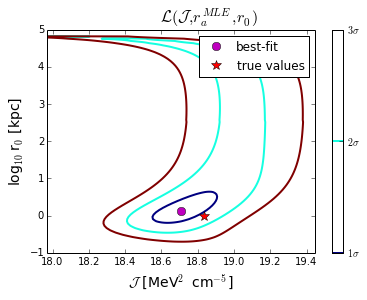

In [109]:
plt.contour(J_array, r0_array,resJr0,[0.5,2.,4.5],linewidths=2)
plt.colorbar(format=ticker.FuncFormatter(fmt))
plt.plot(J_min,J_r0,'mo',label='best-fit',markersize=8)
plt.plot(J_true, np.log10(r0_true), 'r*',label='true values',markersize=10)
plt.xlabel(r'$\mathcal{J}$ [MeV$^2$ cm$^{-5}$]',fontsize=14)
plt.ylabel(r'log$_{10}$ r$_0$ [kpc]',fontsize=14)
plt.legend(numpoints=1).get_frame().set_facecolor('w')
plt.suptitle(r'$\mathcal{L}(\mathcal{J},r^{MLE}_a,r_0)$',fontsize=16)
#plt.savefig('OM_J_r0_cont.png',dpi=300,format='png')

Contour plot of $\mathcal{L}(\mathcal{J},r_a,r^{MLE}_0)$

In [101]:
ra_array = np.linspace(-2,2,100)
J_array = J_min+eJ_min*np.arange(-4,+4+0.05,0.05)

In [23]:
resJra = np.zeros(shape=(ra_array.size, J_array.size))
for i,ra in enumerate(ra_array):
        resJra[i,:] = lh.compute(J_array,ra,J_r0)-minL

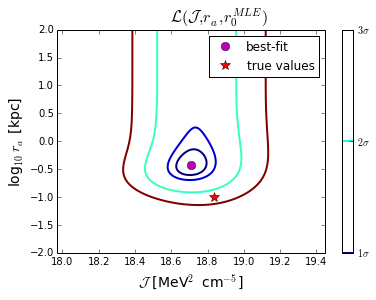

In [102]:
plt.contour(J_array, ra_array,resJra,levels=[0.2,0.5,2.,4.5],linewidths=2)
plt.colorbar(c,format=ticker.FuncFormatter(fmt))
plt.plot(J_min,J_ra,'mo',label='best-fit',markersize=8)
plt.plot(J_true, np.log10(ra_true), 'r*',label='true values',markersize=10)
plt.xlabel(r'$\mathcal{J}$ [MeV$^2$ cm$^{-5}$]',fontsize=14)
plt.ylabel(r'log$_{10}$ $r_a$ [kpc]',fontsize=14)
plt.legend(numpoints=1).get_frame().set_facecolor('w')
plt.suptitle(r'$\mathcal{L}(\mathcal{J},r_a,r^{MLE}_0)$',fontsize=16)
#plt.savefig('OM_J_ra_cont.png',dpi=300,format='png')

Contour plot of $\mathcal{L}(\mathcal{J}^{MLE},r_a,r_0)$

In [112]:
ra_array = np.linspace(-2,4,100)
r0_array = np.linspace(-2,3,100)

In [30]:
resr0ra = np.zeros(shape=(r0_array.size,ra_array.size))
for i,r0 in enumerate(r0_array):
    for j,ra in enumerate(ra_array):
        resr0ra[i,j] = lh.compute(J_min,ra,r0)-minL

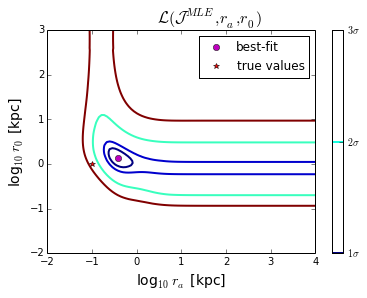

In [114]:
plt.contour(ra_array, r0_array, resr0ra, levels=[0.2,0.5,2.,4.5], linewidths=2)
plt.colorbar(c,format=ticker.FuncFormatter(fmt))
plt.plot(J_ra,J_r0,'mo',label='best-fit')
plt.plot(np.log10(ra_true),np.log10(r0_true), 'r*',label='true values')
plt.xlabel(r'log$_{10}$ $r_a$ [kpc]',fontsize=14)
plt.ylabel(r'log$_{10}$ $r_0$ [kpc]',fontsize=14)
plt.legend(numpoints=1)
plt.suptitle(r'$\mathcal{L}(\mathcal{J}^{MLE},r_a,r_0)$',fontsize=16)
#plt.savefig('OM_ra_r0_cont.png',dpi=300,format='png')